In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    hour, 
    mean, 
    sum, 
    count, 
    date_format, 
    concat, 
    col, 
    lit,  # Added lit
    lpad  # Added lpad
)

In [3]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("ParquetExplorer") \
    .getOrCreate()

# Read the parquet file
#df = spark.read.parquet("C:/Users/reese/OneDrive/Desktop/UTN/Data_Engineering/Group_Project/provisioned/full.parquet")

df = spark.read.parquet("C:/Users/reese/OneDrive/Desktop/UTN/Data_Engineering/Group_Project/output_folder/instance_id=4/data_0_sorted.parquet")

# Show a sample of the data and the schema
df.show(5)
df.printSchema()


+------------+-------+-----------+--------+--------------------+-------------------+-----------------+---------------------+--------------------+-----------+----------+---------------------+----------+-----------------------------+----------------------------+--------------------------+--------------+---------------+--------------+--------------+---------+---------+----------------+-----------+
|cluster_size|user_id|database_id|query_id|   arrival_timestamp|compile_duration_ms|queue_duration_ms|execution_duration_ms| feature_fingerprint|was_aborted|was_cached|cache_source_query_id|query_type|num_permanent_tables_accessed|num_external_tables_accessed|num_system_tables_accessed|read_table_ids|write_table_ids|mbytes_scanned|mbytes_spilled|num_joins|num_scans|num_aggregations|instance_id|
+------------+-------+-----------+--------+--------------------+-------------------+-----------------+---------------------+--------------------+-----------+----------+---------------------+----------+---

In [17]:
# Extract date and hour from arrival_timestamp and create hourly aggregations
hourly_stats = df.groupBy(
        col("instance_id"),  # Group by instance_id
        concat(
            date_format(col("arrival_timestamp"), "yyyyMMdd"),
            lit(" "),
            lpad(hour(col("arrival_timestamp")).cast("string"), 2, "0")
        ).alias("timestamp"),
    ) \
    .agg(
        # Count of queries
        count("*").alias("query_count"),

        # Performance metrics
        #mean("compile_duration_ms").alias("avg_compile_time"),
        #mean("queue_duration_ms").alias("avg_queue_time"),
        sum("execution_duration_ms").alias("total_runtime"),
        
        # Query characteristics
        #mean("cluster_size").alias("avg_cluster_size"),
        #sum("was_cached").alias("total_cached_queries"),
        #sum("was_aborted").alias("total_aborted_queries"),
        
        # Resource usage
        sum("mbytes_scanned").alias("bytes_scanned"),
        #mean("mbytes_spilled").alias("avg_mbytes_spilled"),
        
        # Query complexity metrics
        #mean("num_joins").alias("avg_joins"),
        #mean("num_scans").alias("avg_scans"),
        #mean("num_aggregations").alias("avg_aggregations"),
        
    ) \
    .orderBy("timestamp")

# Display the results
hourly_stats.show(24, truncate=False)

# Save the grouped Spark DataFrame to Parquet
# hourly_stats.write.parquet("hourly_stats.parquet")

# Save as Parquet file
hourly_stats = hourly_stats.toPandas()
hourly_stats.to_parquet("hourly_stats.parquet", engine="pyarrow", compression="snappy")

print("Parquet file saved successfully!")


+-----------+-----------+-----------+-------------+-------------+
|instance_id|timestamp  |query_count|total_runtime|bytes_scanned|
+-----------+-----------+-----------+-------------+-------------+
|4          |20240229 23|1          |1546         |1315.0       |
|4          |20240301 00|8334       |38989865     |2.70649152E8 |
|4          |20240301 01|9573       |18817973     |2.51629065E8 |
|4          |20240301 02|11037      |24512813     |2.19990412E8 |
|4          |20240301 03|9899       |29100500     |2.27740532E8 |
|4          |20240301 04|10166      |26079772     |2.41231024E8 |
|4          |20240301 05|9737       |33418358     |2.14278539E8 |
|4          |20240301 06|9753       |27803892     |2.02991674E8 |
|4          |20240301 07|9625       |31493964     |2.17307191E8 |
|4          |20240301 08|9168       |29827443     |2.11378446E8 |
|4          |20240301 09|9972       |28821738     |2.17369668E8 |
|4          |20240301 10|9866       |28245319     |2.35484676E8 |
|4        

In [19]:
spark.stop()

In [21]:
import pandas as pd
hourly_stats_pd = pd.read_parquet("hourly_stats.parquet")

print(hourly_stats_pd.head())

   instance_id    timestamp  query_count  total_runtime  bytes_scanned
0            4  20240229 23            1           1546         1315.0
1            4  20240301 00         8334       38989865    270649152.0
2            4  20240301 01         9573       18817973    251629065.0
3            4  20240301 02        11037       24512813    219990412.0
4            4  20240301 03         9899       29100500    227740532.0


In [22]:
hourly_stats_pd.dtypes

instance_id        int64
timestamp         object
query_count        int64
total_runtime      int64
bytes_scanned    float64
dtype: object

In [15]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor
import matplotlib.pyplot as plt

# ---------------------------
# 1. Data Preparation
# ---------------------------
# Assume hourly_stats_pd is already loaded as a DataFrame.
# For example, you might load it from a CSV:
# hourly_stats_pd = pd.read_csv("path_to_your_file.csv")

# Display the first few rows of your data
print("Original Data:")
print(hourly_stats_pd.head())

# Convert the 'date_hour' column to datetime.
# Here, the format '%Y%m%d %H' is used to parse strings like "20240229 23".
hourly_stats_pd["timestamp"] = pd.to_datetime(hourly_stats_pd["date_hour"], format="%Y%m%d %H")

# Add the 'item_id' column (even if it's just a single series).
hourly_stats_pd["item_id"] = "ts_0"

# Sort the DataFrame by timestamp.
hourly_stats_pd = hourly_stats_pd.sort_values("timestamp")
print("\nData after adding timestamp and item_id:")
print(hourly_stats_pd.head())

# ---------------------------
# 2. Define Forecasting Settings
# ---------------------------
# We'll forecast the 'total_queries' column.
target_column = "total_queries"

# Set the forecast horizon; here we forecast the next 24 hours.
prediction_length = 24

# ---------------------------
# 3. Split Data into Training and Test Sets
# ---------------------------
# Use the last 10% of the data for testing.
split_index = int(len(hourly_stats_pd) * 0.9)
train_data = hourly_stats_pd.iloc[:split_index].copy()
test_data = hourly_stats_pd.iloc[split_index:].copy()

print(f"\nTraining data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")

# ---------------------------
# 4. Define DeepAR Hyperparameters and Train the Predictor
# ---------------------------
hyperparameters = {
    "DeepAR": {
        "epochs": 100,               # Adjust if needed
        "learning_rate": 1e-3,       # Adjust based on your problem
        "num_layers": 2,             # Number of RNN layers
        "hidden_size": 40,           # Number of neurons in each layer
        "dropout": 0.1,              # Regularization dropout rate
        "batch_size": 32,            # Batch size for training
        "context_length": prediction_length,  # Usually set equal to prediction_length
    }
}

# Create the TimeSeriesPredictor. We specify the frequency as "H" for hourly data.
predictor = TimeSeriesPredictor(
    target=target_column,
    prediction_length=prediction_length,
    freq="H"
)

# Fit the predictor on the training data.
predictor.fit(train_data=train_data, hyperparameters=hyperparameters)

# ---------------------------
# 5. Generate Forecasts on the Test Data
# ---------------------------
forecast = predictor.predict(test_data)
print("\nForecast sample:")
print(forecast.head())

# ---------------------------
# 6. Evaluate the Forecasts using the Leaderboard
# ---------------------------
# The leaderboard displays key error metrics (e.g., SMAPE, MAE, etc.).
lb = predictor.leaderboard(test_data)
print("\nLeaderboard Evaluation:")
print(lb)

No path specified. Models will be saved in: "AutogluonModels/ag-20250212_192642"
/Users/sagnikdas/GitHub/g8/.pyenv/lib/python3.11/site-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'


Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/g8/AutogluonModels/ag-20250212_192642'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       2.14 GB / 8.00 GB (26.7%)
Disk Space Avail:   65.83 GB / 228.27 GB (28.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'batch_size': 32,
                                'context_length': 24,
                                'dropout': 0.1,
                                'epochs': 100,
                                'hidden_size': 40,
                                'learning_rate': 0.001,
                                'num_layers': 2}},
 'known_covar

Original Data:
     date_hour  avg_compile_time  avg_queue_time  avg_execution_time  \
0  20240229 23        776.322581        0.000000         2565.232558   
1  20240301 00       3136.085096     1362.784185         3149.008982   
2  20240301 01       2865.861695     2366.942083         2858.041195   
3  20240301 02       3247.703790     3082.742425         3358.603835   
4  20240301 03       3472.503981     1734.145884         3642.121047   

   avg_cluster_size  total_cached_queries  total_aborted_queries  \
0          7.565217                    12                      1   
1          6.424787                 14243                   1546   
2          7.291368                 16201                   1686   
3          7.161010                 13458                   1496   
4          6.865767                 11179                   1459   

   avg_mbytes_scanned  avg_mbytes_spilled  avg_joins  avg_scans  \
0         3976.516129            0.000000   0.906977   1.046512   
1        

	-0.1102       = Validation score (-WQL)
	39.52   s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Not fitting ensemble as only 1 model was trained.
Training complete. Models trained: ['DeepAR']
Total runtime: 39.59 s
Best model: DeepAR
Best model score: -0.1102
Model not specified in predict, will default to the model with the best validation score: DeepAR
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).



Forecast sample:
                                      mean           0.1            0.2  \
item_id timestamp                                                         
ts_0    2024-05-31 01:00:00   72498.273438  65932.742969   67867.415625   
        2024-05-31 02:00:00   89062.531250  77541.017188   82116.895312   
        2024-05-31 03:00:00   98737.796875  80609.907812   87767.873438   
        2024-05-31 04:00:00  116690.570312  86889.235156   99819.253125   
        2024-05-31 05:00:00  129462.328125  91745.983594  106768.029688   

                                       0.3            0.4            0.5  \
item_id timestamp                                                          
ts_0    2024-05-31 01:00:00   69888.418750   71273.789062   72289.136719   
        2024-05-31 02:00:00   84807.819531   87344.182813   89760.742188   
        2024-05-31 03:00:00   91614.507812   95407.910937   98297.667969   
        2024-05-31 04:00:00  105887.084375  112719.910937  117472.304688   


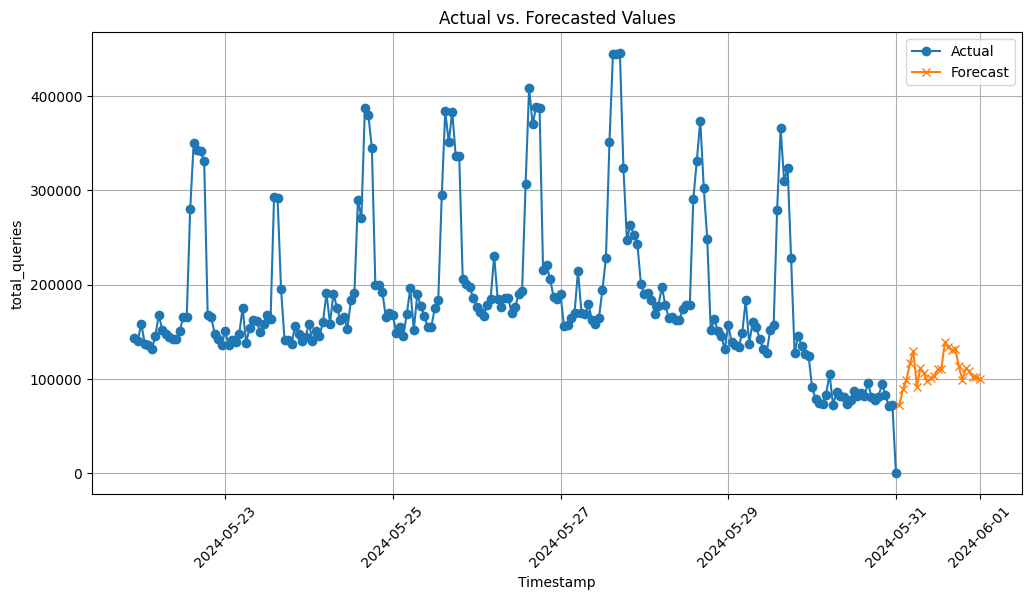

In [22]:
# Ensure test data has timestamp as a column
if test_data.index.name == "timestamp":
    test_data = test_data.reset_index()

# Sort both DataFrames by timestamp
test_data = test_data.sort_values("timestamp")
forecast = forecast.sort_values("timestamp")

# Now plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test_data["timestamp"], test_data[target_column], label="Actual", marker="o")
plt.plot(forecast["timestamp"], forecast["mean"], label="Forecast", marker="x")  # Use "mean" for forecasted values
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.title("Actual vs. Forecasted Values")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()